# Quickstart

In [2]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import openml
from sklearn.model_selection import train_test_split
import numpy as np
import os

## Loading the dataset

This tutorial introduces you to a complete machine learning pipeline to run DRAGON for a simple classification task on the *PenDigits* dataset.

In [3]:
dataset = openml.datasets.get_dataset(32)
data, _, numerical, names = dataset.get_data()
data.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,class
0,47.0,100.0,27.0,81.0,57.0,37.0,26.0,0.0,0.0,23.0,56.0,53.0,100.0,90.0,40.0,98.0,8
1,0.0,89.0,27.0,100.0,42.0,75.0,29.0,45.0,15.0,15.0,37.0,0.0,69.0,2.0,100.0,6.0,2
2,0.0,57.0,31.0,68.0,72.0,90.0,100.0,100.0,76.0,75.0,50.0,51.0,28.0,25.0,16.0,0.0,1
3,0.0,100.0,7.0,92.0,5.0,68.0,19.0,45.0,86.0,34.0,100.0,45.0,74.0,23.0,67.0,0.0,4
4,0.0,67.0,49.0,83.0,100.0,100.0,81.0,80.0,60.0,60.0,40.0,40.0,33.0,20.0,47.0,0.0,1


In [7]:
X = data.drop('class', axis=1)
X = (X - X.min(axis=0))/(X.max(axis=0) - X.min(axis=0))
y = data[["class"]].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Number of features: {X.shape[1]}, number of classes: {y.shape[1]}")

X_train: (7694, 16), y_train: (7694, 1), X_val: (3298, 16), y_val: (3298, 1)
Number of features: 16, number of classes: 1


In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.FloatTensor(X.values)
        self.y = torch.LongTensor(y.values)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.y[index]
train_set = CustomDataset(X_train, y_train)
val_set = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

## Search Space

In **DRAGON** the neural networks are represented as *Directed Acyclic Graphs (DAGs)*, where each node represents `nn.Module` layer, and the edges are the connection between them. Within the package, the DAGs are encoded using their adjaceny matrix. To know more about these objects, refer to the [Search Space](../Search_Space/index.rst) section.

### Meta-Architecture

The meta-architecture $f$ should encompasses all the considered neural networks from the search space. To define a meta-architecture usable with **DRAGON**, we create a class that inherits from `nn.Module`. The `__init__` function should take as input arguments defining a certain set of architecture and hyperparameters $\{\alpha, \theta\}$. Then, the `__forward__` function should take an input a variable $X$ and returns the prediction $\hat{y} = f_{\alpha,\theta}(X)$.

The main bricks to build neural networks within the **DRAGON** package are `dragon.search_space.cells.AdjMatrix` and `dragon.search_space.cells.Node`. The `AdjMatrix` creates a DAG and the `Node` a simple layer. Both bricks can be used to create models adapted to the task at hand. In this case we stay very simple with a single `AdjMatrix` embodying the neural network and a final `Node` to get the right output shape.

Before the first training of a given neural network, the layers should be initialized with the right input shape.

In [9]:
from dragon.search_space.dag_encoding import AdjMatrix, Node

class MetaArchi(nn.Module):
    def __init__(self, args, input_shape):
        super().__init__()
        # Number of features, here equals to 16
        self.input_shape = input_shape

        # We create the DAG using the WeightsAdjCell module
        assert isinstance(args['Dag'], AdjMatrix), f"The 'Dag' argument should be an 'AdjMatrix'. Got {type(args['Dag'])} instead."
        self.dag = args['Dag']
        self.dag.set(input_shape)

        # We set the final layer
        assert isinstance(args['Out'], Node), f"The 'Out' argument should be a 'Node'. Got {type(args['Node'])} instead."
        self.output = args["Out"]
        self.output.set(self.dag.output_shape)

    def forward(self, X):
        out = self.dag(X)
        return self.output(out)
    
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        full_path = os.path.join(path, "best_model.pth")
        torch.save(self.state_dict(), full_path)

### Arguments

The `MetaArchi` class takes as input a dictionnary `args` containing one search space configuration ${\alpha, \theta}$. We now need to define what values $\alpha$ and $\theta$ can take. To keep it simple, we will only use `nn.Linear` and `nn.Identity` layers as candidate operations. Several ready-to-use candidate operations are available within `dragon.search_space.bricks_variables`. They are then used to build Directed Acyclic Graphs.

In [10]:
from dragon.search_space.bricks_variables import mlp_var, identity_var, operations_var, mlp_const_var, dag_var, node_var

candidate_operations = operations_var("Candidate operations", size=10, candidates=[mlp_var("MLP"), identity_var("Identity")])
dag = dag_var("Dag", candidate_operations)
print(f'An example of a generated DAG: {dag.random()}')

# For the last layer, we do not want the number of output channels to be optimized. It should be equal to the number of classes.
out = node_var("Out", operation=mlp_const_var('Operation', 10), activation_function=nn.Identity())

An example of a generated DAG: NODES: [
(combiner) add -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) add -- (name) <class 'dragon.search_space.bricks.basics.MLP'> -- (hp) {'out_channels': 343} -- (activation) Identity() -- , 
(combiner) concat -- (name) <class 'dragon.search_space.bricks.basics.MLP'> -- (hp) {'out_channels': 8} -- (activation) ELU(alpha=1.0) -- , 
(combiner) mul -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) LeakyReLU(negative_slope=0.01) -- ] | MATRIX:[[0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 0, 1], [0, 0, 0, 0]]


With the elements `dag` and `out` we can generate composants to build a neural network.

In [11]:
args = {"Dag": dag.random(), "Out": out.random()}
model = MetaArchi(args, input_shape=(16,))

The final search space is an array which contain all the structural elements of the architecture as well as eventually other elements for the training for example.

In [12]:
from dragon.search_space.base_variables import ArrayVar
from dragon.search_operators.base_neighborhoods import ArrayInterval

search_space = ArrayVar(dag, out, label="Search Space", neighbor=ArrayInterval())

## Loss function

The search algorithm should minimize a certain loss function. Typically, it consists in training the model on a train set and then validate it on a validation set.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    model.train()
    for _ in range(5):
        for X,y in data_loader:
            optimizer.zero_grad()
            X = X.to(device)
            y = y.squeeze().to(device)
            pred = model(X)
            loss = loss_fn(pred,y)
            loss.backward()
            optimizer.step()
    return model

def test_model(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for X, y in data_loader:
          X = X.to(device)
          y = y.squeeze(1).to(device)
          pred = model(X)
          loss = loss_fn(pred, y).item()
          test_loss += loss
          prediction = pred.argmax(axis=1)
          correct += (prediction == y).sum().item()
    accuracy = correct/ len(data_loader.dataset)
    return accuracy

def loss_function(args, idx, *kwargs):
    labels = [e.label for e in search_space]
    args = dict(zip(labels, args))
    model = MetaArchi(args, input_shape=(16,)).to(device)
    model = train_model(model, train_loader)
    accuracy = test_model(model, val_loader)
    print(f"Idx = {idx}, accuracy = {accuracy}")
    return 1 - accuracy, model

loss, model = loss_function(search_space.random(), idx="test")
print(f'For a given argument, accuracy = ', np.round((1-loss)*100,2), '%')

Idx = test, accuracy = 0.834445118253487
For a given argument, accuracy =  83.44 %


## Search Algorithm

We can use several search algorithms to optimize the structures from the search space. Here, we take the example of Mutant-UCB.

In [24]:
from dragon.search_algorithm.mutant_ucb import Mutant_UCB

search_algorithm = Mutant_UCB(search_space, save_dir="save/test_mutant", T=20, N=5, K=5, E=0.01, evaluation=loss_function)
search_algorithm.run()

2025-02-24 11:36:01,071 | WARNING | Install mpi4py if you want to use the distributed version.


INFO:root:save/test_mutant already exists. Deleting it.


2025-02-24 11:36:01,074 | INFO | save/test_mutant already exists. Deleting it.


INFO:root:The whole population has been created (size = 5), 5 have been randomy initialized.


2025-02-24 11:36:01,088 | INFO | The whole population has been created (size = 5), 5 have been randomy initialized.


INFO:root:Best found! 0.18223165554881748 < inf


Idx = 0, accuracy = 0.8177683444511825
2025-02-24 11:36:09,474 | INFO | Best found! 0.18223165554881748 < inf


INFO:root:Best found! 0.03850818677986656 < 0.18223165554881748


Idx = 1, accuracy = 0.9614918132201334
2025-02-24 11:36:34,380 | INFO | Best found! 0.03850818677986656 < 0.18223165554881748
Idx = 2, accuracy = 0.9226804123711341
Idx = 3, accuracy = 0.8963007883565798


INFO:root:All models have been at least evaluated once, t = 5 < 20.


Idx = 4, accuracy = 0.9481503941782898
2025-02-24 11:37:16,963 | INFO | All models have been at least evaluated once, t = 5 < 20.


INFO:root:After initialisation, it remains 15 iterations.


2025-02-24 11:37:16,965 | INFO | After initialisation, it remains 15 iterations.


INFO:root:With p = 0.2 = 1 / 5, training 1 instead


2025-02-24 11:37:16,967 | INFO | With p = 0.2 = 1 / 5, training 1 instead


INFO:root:Best found! 0.02122498483929658 < 0.03850818677986656


Idx = 1, accuracy = 0.9787750151607034
2025-02-24 11:37:43,707 | INFO | Best found! 0.02122498483929658 < 0.03850818677986656


INFO:root:With p = 0.2 = 1 / 5, training 4 instead


2025-02-24 11:37:43,800 | INFO | With p = 0.2 = 1 / 5, training 4 instead


INFO:root:Best found! 0.017283201940570092 < 0.02122498483929658


Idx = 4, accuracy = 0.9827167980594299
2025-02-24 11:38:01,945 | INFO | Best found! 0.017283201940570092 < 0.02122498483929658


INFO:root:With p = 0.4 = 2 / 5, training 1 instead


2025-02-24 11:38:02,015 | INFO | With p = 0.4 = 2 / 5, training 1 instead


INFO:root:With p = 0.4 = 2 / 5, mutating 4 to 5


Idx = 1, accuracy = 0.9805942995755003
2025-02-24 11:38:29,023 | INFO | With p = 0.4 = 2 / 5, mutating 4 to 5


INFO:root:With p = 0.2 = 1 / 5, training 5 instead


Idx = 5, accuracy = 0.9796846573681018
2025-02-24 11:38:47,217 | INFO | With p = 0.2 = 1 / 5, training 5 instead


INFO:root:Best found! 0.01667677380230448 < 0.017283201940570092


Idx = 5, accuracy = 0.9833232261976955
2025-02-24 11:39:05,183 | INFO | Best found! 0.01667677380230448 < 0.017283201940570092


INFO:root:With p = 0.4 = 2 / 5, mutating 5 to 6


2025-02-24 11:39:05,241 | INFO | With p = 0.4 = 2 / 5, mutating 5 to 6


INFO:root:With p = 0.2 = 1 / 5, training 6 instead


Idx = 6, accuracy = 0.9727107337780473
2025-02-24 11:39:21,746 | INFO | With p = 0.2 = 1 / 5, training 6 instead


INFO:root:Best found! 0.010612492419648234 < 0.01667677380230448


Idx = 6, accuracy = 0.9893875075803518
2025-02-24 11:39:38,748 | INFO | Best found! 0.010612492419648234 < 0.01667677380230448


INFO:root:With p = 0.4 = 2 / 5, training 6 instead


2025-02-24 11:39:38,820 | INFO | With p = 0.4 = 2 / 5, training 6 instead


INFO:root:Best found! 0.010309278350515427 < 0.010612492419648234


Idx = 6, accuracy = 0.9896907216494846
2025-02-24 11:39:55,594 | INFO | Best found! 0.010309278350515427 < 0.010612492419648234


INFO:root:With p = 0.6 = 3 / 5, mutating 6 to 7


2025-02-24 11:39:55,672 | INFO | With p = 0.6 = 3 / 5, mutating 6 to 7


INFO:root:With p = 0.2 = 1 / 5, training 7 instead


Idx = 7, accuracy = 0.9896907216494846
2025-02-24 11:40:13,794 | INFO | With p = 0.2 = 1 / 5, training 7 instead


INFO:root:With p = 0.4 = 2 / 5, mutating 7 to 8


Idx = 7, accuracy = 0.9896907216494846
2025-02-24 11:40:31,506 | INFO | With p = 0.4 = 2 / 5, mutating 7 to 8


INFO:root:Best found! 0.008489993935718587 < 0.010309278350515427


Idx = 8, accuracy = 0.9915100060642814
2025-02-24 11:40:52,735 | INFO | Best found! 0.008489993935718587 < 0.010309278350515427


INFO:root:With p = 0.2 = 1 / 5, training 8 instead


2025-02-24 11:40:52,821 | INFO | With p = 0.2 = 1 / 5, training 8 instead


INFO:root:With p = 0.4 = 2 / 5, mutating 8 to 9


Idx = 8, accuracy = 0.9915100060642814
2025-02-24 11:41:13,362 | INFO | With p = 0.4 = 2 / 5, mutating 8 to 9


INFO:root:With p = 0.4 = 2 / 5, training 8 instead


Idx = 9, accuracy = 0.9220739842328685
2025-02-24 11:41:37,345 | INFO | With p = 0.4 = 2 / 5, training 8 instead


INFO:root:With p = 0.4 = 2 / 5, training 7 instead


Idx = 8, accuracy = 0.9893875075803518
2025-02-24 11:41:58,347 | INFO | With p = 0.4 = 2 / 5, training 7 instead


INFO:root:Best found! 0.007883565797452974 < 0.008489993935718587


Idx = 7, accuracy = 0.992116434202547
2025-02-24 11:42:15,931 | INFO | Best found! 0.007883565797452974 < 0.008489993935718587


INFO:root:Search algorithm is done. Min Loss = 0.007883565797452974


2025-02-24 11:42:15,987 | INFO | Search algorithm is done. Min Loss = 0.007883565797452974


## Draw Graph

After the optimization, it is possible to load the best graph and draw the architecture.

Model giving a score of  99.21 %:


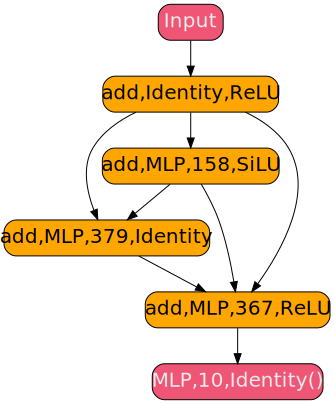

In [26]:
import graphviz
from dragon.utils.plot_functions import draw_cell, load_archi, str_operations

def draw_graph(n_dag, m_dag, output_file, act="Identity()", name="Input"):
    G = graphviz.Digraph(output_file, format='pdf',
                            node_attr={'nodesep': '0.02', 'shape': 'box', 'rankstep': '0.02', 'fontsize': '20', "fontname": "sans-serif"})

    G, g_nodes = draw_cell(G, n_dag, m_dag, "#ffa600", [], name_input=name,
                            color_input="#ef5675")
    G.node(','.join(["MLP", "10", act]), style="rounded,filled", color="black", fillcolor="#ef5675", fontcolor="#ECECEC")
    G.edge(g_nodes[-1], ','.join(["MLP", "10", act]))
    return G

best_model = load_archi("save/test_mutant/best_model/x.pkl")
labels = [e.label for e in search_space]
best_model = dict(zip(labels, best_model))
m_dag = best_model['Dag'].matrix
n_dag = str_operations(best_model["Dag"].operations)

graph = draw_graph(n_dag, m_dag, "save/_mutant/best_archi")
print(f'Model giving a score of ', np.round((1-search_algorithm.min_loss)*100, 2), '%:')
graph

### Baseline: SVC / RandomForest with Optuna

In [ ]:
import sklearn
import optuna
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def objective(trial):

    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if classifier_name == 'SVC':
         svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
         classifier_obj = SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)
    classifier_obj.fit(X_train, y_train, )
    pred = classifier_obj.predict(X_val)
    accuracy = accuracy_score(y_val, pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f"\nBest Accuracy: ", np.round(study.best_value,2)*100)

[I 2024-09-30 08:31:47,051] A new study created in memory with name: no-name-56c0c993-5fe9-4734-b454-5c7296a0f970
[I 2024-09-30 08:31:47,147] Trial 0 finished with value: 0.9802910855063675 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 9}. Best is trial 0 with value: 0.9802910855063675.
[I 2024-09-30 08:31:47,192] Trial 1 finished with value: 0.7947240751970891 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 0 with value: 0.9802910855063675.
[I 2024-09-30 08:31:53,258] Trial 2 finished with value: 0.11552456033959976 and parameters: {'classifier': 'SVC', 'svc_c': 107434903.85230298}. Best is trial 0 with value: 0.9802910855063675.
[I 2024-09-30 08:31:59,078] Trial 3 finished with value: 0.11552456033959976 and parameters: {'classifier': 'SVC', 'svc_c': 76.05790764453474}. Best is trial 0 with value: 0.9802910855063675.
[I 2024-09-30 08:32:04,722] Trial 4 finished with value: 0.11552456033959976 and parameters: {'classifier': 'SVC', 'svc


Best Accuracy:  99.0
